In [1]:
suppressMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(GenomicFiles)
    library(rtracklayer)
    library(data.table)
    library(scales)
    library(limma)
});

options(repr.plot.width=2, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml", bitmapType="cairo", digits=3);
theme_set( theme_classic() );
mycols = c( 'dodgerblue', 'gray', 'forestgreen' );

In [2]:
ESize = fasta.seqlengths("./data/eSTARR_EnhFusions.fa.gz");
BCTable = read.csv("./data/eSTARR_EnhFusions_UMIcounts.csv", sep="\t", header=T );
BCTable$Element = as.character(BCTable$Element);
rownames(BCTable) = BCTable$Element;
BCTable[,-1] = t( 1E6 / colSums(BCTable[,-1]) * t(BCTable[,-1]) );

nDNA = BCTable[, grepl('DNA', colnames(BCTable), fixed=T) ];
skip = apply(nDNA, 1, min) < 30;
BCTable = BCTable[!skip,];
head(BCTable);

,Element,DNA1,DNA2,DNA3,Input,RNA1,RNA2,RNA3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KSUUT0003_KSUUT0003,KSUUT0003_KSUUT0003,5130.6,7923.3,8878.3,3622.2,5844.1,4158.5,5117.4
KSUUT0003_KSUUT0008,KSUUT0003_KSUUT0008,6864.9,9913.5,12865.2,4289.1,25372.5,12101.0,21025.6
KSUUT0003_KSUUT0025,KSUUT0003_KSUUT0025,4536.3,6706.2,7740.8,2957.1,4034.2,2888.6,4277.8
KSUUT0003_KSUUT0100,KSUUT0003_KSUUT0100,37.6,97.8,94.5,22.9,79.1,51.1,64.8
KSUUT0003_KSUUT0114,KSUUT0003_KSUUT0114,3706.8,8126.6,6522.1,2251.5,4852.2,3586.4,4643.8
KSUUT0003_KUUAE0004,KSUUT0003_KUUAE0004,4837.5,6372.4,8345.5,3025.6,6732.0,3716.0,6108.6


In [3]:
nDNA = BCTable[, grepl('DNA', colnames(BCTable), fixed=T) ];
nRNA = BCTable[, grepl('RNA' , colnames(BCTable), fixed=T) ];
colnames(nDNA) = gsub('DNA', '', colnames(nDNA), fixed=T);
colnames(nRNA) = colnames(nDNA);

Preformatted = cbind(nRNA, nDNA);
coldata = data.frame(
    RvD=rep(c(1, 0), each=3),
    Rep=1:3
);
mdes = model.matrix(~RvD, data=coldata);
vdata = voomWithQualityWeights(Preformatted, design=mdes, plot=F);
vcorrf = duplicateCorrelation(vdata, mdes, block = coldata$Rep)$consensus.correlation;

fit = eBayes(lmFit(vdata, mdes, block = coldata$Rep, correlation = vcorrf));
hits = topTable(fit, coef='RvD', number=Inf, sort.by = "none");

# +2 to logFC aligns this dataset to previous eSTARR
# dataset which was normalized to neutral controls.
# See cell 7 below for comparison plot.
vnorm = hits;
vnorm$normFC = vnorm$logFC+2;
vnorm$Element=as.character(rownames(vnorm));
vnorm = vnorm[,c("Element", "normFC", "P.Value")];
head(vnorm);

Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”


,Element,normFC,P.Value
,<chr>,<dbl>,<dbl>
KSUUT0003_KSUUT0003,KSUUT0003_KSUUT0003,1.45,0.02434
KSUUT0003_KSUUT0008,KSUUT0003_KSUUT0008,3.12,0.00193
KSUUT0003_KSUUT0025,KSUUT0003_KSUUT0025,1.31,0.00945
KSUUT0003_KSUUT0100,KSUUT0003_KSUUT0100,1.66,0.31572
KSUUT0003_KSUUT0114,KSUUT0003_KSUUT0114,1.41,0.03060
KSUUT0003_KUUAE0004,KSUUT0003_KUUAE0004,1.91,0.69541


In [4]:
norm=vnorm;
nrow(norm)

ele1 = substr(norm$Element, 1, 9);
ele2 = substr(norm$Element, 11, 19);
eles = unique(append(ele1, ele2));
diff = ele1 != ele2;
sum(diff)

singles = as.data.frame(norm[!diff,]);
singles$ID = ele1[!diff];
rownames(singles) = singles$ID;

[1] 234

[1] 188

In [5]:
fused = as.data.frame( norm[diff,] );
nrow(fused);

ele1 = substr(fused$Element, 1, 9);
ele2 = substr(fused$Element, 11, 19);
fused = cbind( fused, ele1, ele2, singles[ele1,2], singles[ele2,2] );
rownames(fused) = NULL;
rm(ele1, ele2);

colnames(fused) = c( "Element", "A", "A.p", "ele1", "ele2", "B", "C" );
fused$e1 = ifelse(fused$B > fused$C, fused$B, fused$C);
fused$e2 = ifelse(fused$B > fused$C, fused$C, fused$B);

[1] 188

In [6]:
Summary = read.csv("./data/K562_eSTARR_voom.csv", header=T);
Summary$ID = as.character(Summary$ID);
enh = Summary %>% filter(logFC.CW>=1) %>% select(ID);
Summary = Summary %>% filter(ID %in% eles);
head(Summary);
enh = unique(enh$ID);

out = left_join(Summary, singles, by="ID");

,logFC.CW,ID,p.CW,logFC.CCW,p.CCW,logFC,call,Size
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,3.89,KUUUT0043,1.89e-22,3.96,1.52e-22,3.93,Enhancer,299
2,3.31,KUUAE0071,2.23e-20,4.24,1.89e-22,3.85,Enhancer,270
3,3.21,KSUUT0008,2.23e-20,3.86,1.89e-22,3.57,Enhancer,292
4,3.13,KUUUT0021,1.55e-20,3.50,3.96e-22,3.33,Enhancer,280
5,2.88,KUUAE0147,4.24e-19,2.94,4.61e-20,2.91,Enhancer,252
6,2.54,KUUAE0034,1.60e-17,2.62,5.55e-19,2.58,Enhancer,299


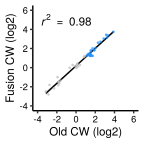

In [7]:
lm_eqn2 = function(x, y) {
    ct = cor.test(x, y);
    eq = substitute(italic(r^2)~"="~ rval, # ~"  "~italic(p) == pv,
        list( #pv = format(ct$p.value, digits = 2),
             rval = format(unname(ct$estimate^2), digits = 2)));
    return(as.character(as.expression(eq)));
}

print(
    ggplot(out, aes(x=logFC.CW, y=normFC, col=logFC.CW < 1)) +
    xlab("Old CW (log2)") + ylab("Fusion CW (log2)") +
    xlim(-4, 6) + ylim(-4, 6) + 
    geom_smooth( formula=y~x, method='lm', col='black', lwd=0.5 ) +
    geom_text(aes( -1, 5, label = lm_eqn2(out$logFC.CW, out$normFC)), data=data.frame(), parse = T, col='black' ) +
    geom_point(alpha=0.75, pch=19, show.legend=F, size=0.75, stroke=0) +
    scale_color_manual(values=mycols)
);
#ggsave("../out/TREF_Replication.pdf", width=2, height=2);

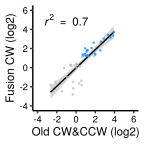

In [8]:
print(
    ggplot(out, aes(x=logFC, y=normFC, col=logFC.CW < 1)) +
    xlab("Old CW&CCW (log2)") + ylab("Fusion CW (log2)") +
    xlim(-4, 6) + ylim(-4, 6) + 
    geom_smooth( formula=y~x, method='lm', col='black', lwd=0.5 ) +
    geom_text(aes( -1, 5, label = lm_eqn2(out$logFC, out$normFC)), data=data.frame(), parse = T, col='black' ) +
    geom_point(alpha=0.75, pch=19, show.legend=F, size=0.75, stroke=0) +
    scale_color_manual(values=mycols)
);

Warning message:
“Removed 56 rows containing missing values (geom_point).”
Warning message:
“Removed 56 rows containing missing values (geom_point).”


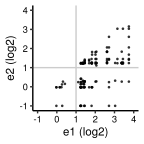

In [9]:
print(
    ggplot(fused, aes(e1, e2)) +
    xlim(-1, 4) + ylim(-1, 4) +
    xlab("e1 (log2)") + ylab("e2 (log2)") +
    geom_hline(aes(yintercept=1), col="#cccccc") +
    geom_vline(aes(xintercept=1), col="#cccccc") +
    geom_point(alpha=0.8, size=0.75, pch=16, stroke=0)
);
ggsave("../out/TREF_E1vE2.pdf", width=2, height=2);

In [10]:
print("enhancer-enhancer pairs");
ffused = fused[fused$ele1 %in% enh & fused$ele2 %in% enh,];
nrow(ffused);

[1] "enhancer-enhancer pairs"


[1] 69

Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


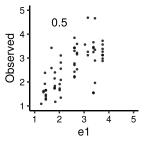

In [11]:
tibble(y=ffused$A, x=ffused$e1) %>% ggplot(aes(x, y)) +
    xlab("e1") + ylab("Observed") +
    xlim(1, 5) + ylim(1, 5) +
#    geom_smooth(method="lm", col="black", lwd=0.5) +
    geom_point(alpha=0.8, pch=19, show.legend=F, size=0.75, stroke=0) +
    geom_text( data=data.frame(), aes(x=2, y=4.5, label=round(cor.test(ffused$A, ffused$e1)$estimate^2,3)) );
ggsave("../out/TREF_EnhMax.pdf", width=2, height=2);

Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


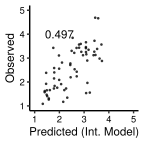

In [12]:
intm = lm( A ~ e1 * e2, data=ffused );
tibble(y=ffused$A, x=intm$fitted) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Int. Model)") + ylab("Observed") +
    xlim(1, 5) + ylim(1, 5) +
    geom_point(alpha=0.8, pch=19, show.legend=F, size=0.75, stroke=0) +
    geom_text( data=data.frame(), aes(x=2, y=4, label=round(summary(intm)$adj.r.squared,3)) );
ggsave("../out/TREF_EnhSum.pdf", width=2, height=2);

Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


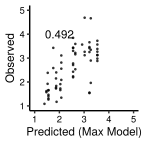

In [13]:
maxm = lm( A ~ e1, data=ffused );
tibble(y=ffused$A, x=maxm$fitted) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Max Model)") + ylab("Observed") +
    xlim(1, 5) + ylim(1, 5) +
    geom_point(alpha=0.8, pch=19, show.legend=F, size=0.75, stroke=0) +
    geom_text( data=data.frame(), aes(x=2, y=4, label=round(summary(maxm)$adj.r.squared,3)) );
ggsave("../out/TREF_EnhMaxMod.pdf", width=2, height=2);

In [14]:
summary(intm);


Call:
lm(formula = A ~ e1 * e2, data = ffused)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6744 -0.3288  0.0277  0.4601  1.6731 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -0.968      1.429   -0.68    0.500  
e1             1.102      0.445    2.47    0.016 *
e2             1.017      1.030    0.99    0.327  
e1:e2         -0.224      0.309   -0.72    0.472  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.721 on 65 degrees of freedom
Multiple R-squared:  0.519,	Adjusted R-squared:  0.497 
F-statistic: 23.4 on 3 and 65 DF,  p-value: 2.2e-10


In [15]:
summary(maxm);


Call:
lm(formula = A ~ e1, data = ffused)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6794 -0.3734  0.0097  0.4452  1.6738 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.306      0.271    1.13     0.26    
e1             0.862      0.105    8.18  1.1e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.724 on 67 degrees of freedom
Multiple R-squared:   0.5,	Adjusted R-squared:  0.492 
F-statistic: 66.9 on 1 and 67 DF,  p-value: 1.13e-11


In [16]:
anova(maxm, intm);

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,67,35.1,NA,NA,NA,NA
2,65,33.8,2,1.36,1.31,0.278


[1] "test on enhancer-inactive pairs"


Warning message:
“Removed 9 rows containing missing values (geom_point).”
Warning message:
“Removed 9 rows containing missing values (geom_point).”


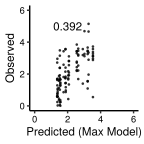

In [23]:
print("test on enhancer-inactive pairs");
nfused = fused[(fused$ele1 %in% enh | fused$ele2 %in% enh) & fused$e2 > -1,];
mout = predict( maxm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Max Model)") + ylab("Observed") +
    xlim(0, 6) + ylim(0, 6) +
    geom_point(alpha=0.8, pch=19, show.legend=F, size=0.75, stroke=0) +
    geom_text( data=data.frame(), aes(x=2, y=5, label=rsq) );
ggsave("../out/TREF_EnhPairs.pdf", width=2, height=2);

[1] "test on inactive-inactive pairs"


Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


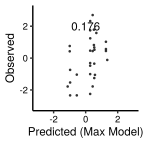

In [24]:
print("test on inactive-inactive pairs");
nfused = fused[!(fused$ele1 %in% enh | fused$ele2 %in% enh),];
mout = predict( maxm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>%
ggplot(aes(x, y)) +
    xlab("Predicted (Max Model)") + ylab("Observed") +
    xlim(-3, 3) + ylim(-3, 3) +
    geom_point(alpha=0.8, pch=19, show.legend=F, size=0.75, stroke=0) +
    geom_text( data=data.frame(), aes(x=0, y=2, label=rsq) );
ggsave("../out/TREF_NonenhPairs.pdf", width=2, height=2);

Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


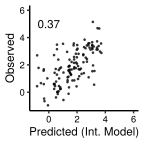

In [28]:
# test interaction vs max models on full dataset
nfused = fused[fused$e2 > -1,];
mout = predict( intm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>%
ggplot(aes(x, y)) +
    xlab("Predicted (Int. Model)") + ylab("Observed") +
    xlim(-1, 6) + ylim(-1, 6) +
    geom_point(alpha=0.8, pch=19, show.legend=F, size=0.75, stroke=0) +
    geom_text( data=data.frame(), aes(x=0, y=5, label=rsq) );
ggsave("../out/TREF_AllPairs_IntMod.pdf", width=2, height=2);

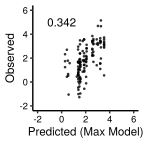

In [31]:
mout = predict( maxm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>%
ggplot(aes(x, y)) +
    xlab("Predicted (Max Model)") + ylab("Observed") +
    xlim(-1, 6) + ylim(-1, 6) +
    geom_point(alpha=0.8, pch=19, show.legend=F, size=0.75, stroke=0) +
    geom_text( data=data.frame(), aes(x=0, y=5, label=rsq) );
ggsave("../out/TREF_AllPairs_MaxMod.pdf", width=2, height=2);

In [21]:
head(fused)

,Element,A,A.p,ele1,ele2,B,C,e1,e2
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,KSUUT0003_KSUUT0008,3.12,0.00193,KSUUT0003,KSUUT0008,1.45,3.15,3.15,1.45
2,KSUUT0003_KSUUT0025,1.31,0.00945,KSUUT0003,KSUUT0025,1.45,1.36,1.45,1.36
3,KSUUT0003_KSUUT0100,1.66,0.31572,KSUUT0003,KSUUT0100,1.45,1.42,1.45,1.42
4,KSUUT0003_KSUUT0114,1.41,0.03060,KSUUT0003,KSUUT0114,1.45,1.27,1.45,1.27
5,KSUUT0003_KUUAE0004,1.91,0.69541,KSUUT0003,KUUAE0004,1.45,2.01,2.01,1.45
6,KSUUT0003_KUUAE0024,1.76,0.29409,KSUUT0003,KUUAE0024,1.45,1.81,1.81,1.45


In [33]:
enh = out$ID[out$logFC.CW>1];
EEPs = fused$ele1 %in% enh & fused$ele2 %in% enh;
ENPs = xor(fused$ele1 %in% enh, fused$ele2 %in% enh);
NNPs = !fused$ele1 %in% enh & !fused$ele2 %in% enh;
sum(EEPs & fused$A >1)/sum(EEPs)
sum(ENPs & fused$A >1)/sum(ENPs)
sum(NNPs & fused$A >1)/sum(NNPs)

[1] 0.899

[1] 0.5

[1] 0.212

In [36]:
sum(!unique(singles$ID) %in% enh)

[1] 22

In [39]:
sum(EEPs & fused$A >1)
sum(ENPs & fused$A >1)
sum(NNPs & fused$A >1)

[1] 62

[1] 43

[1] 7